## Prajwal Luitel (C0927658)

#### Social Media Analytics

### 2nd February, 2025

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('bike_sharing_data.csv')
print(f"Dataset Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset Shape: (17379, 12)

First few rows:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1/1/2011 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1/1/2011 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1/1/2011 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1/1/2011 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1/1/2011 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

#### Datetime conversion

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['dayofweek'] = df['datetime'].dt.dayofweek

#### Feature engineering for peak hour

In [7]:
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if (x >= 7 and x <= 9) or (x >= 16 and x <= 18) else 0)

print("\nFeatures created from datetime:")
df[['hour', 'day', 'month', 'year', 'dayofweek', 'is_peak_hour']].head()



Features created from datetime:


,hour,day,month,year,dayofweek,is_peak_hour
0,0,1,1,2011,5,0
1,1,1,1,2011,5,0
2,2,1,1,2011,5,0
3,3,1,1,2011,5,0
4,4,1,1,2011,5,0


#### EDA

##### Correlation Heatmap

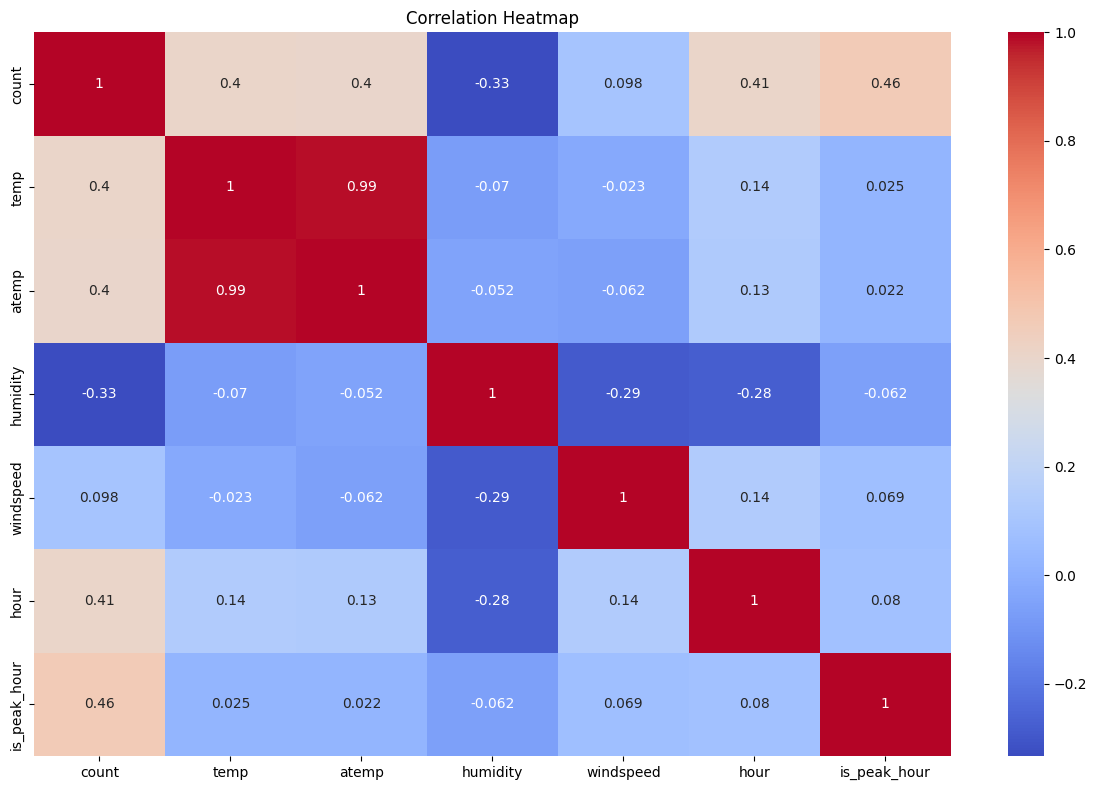

In [8]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[['count', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'is_peak_hour']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

##### Distribution plot

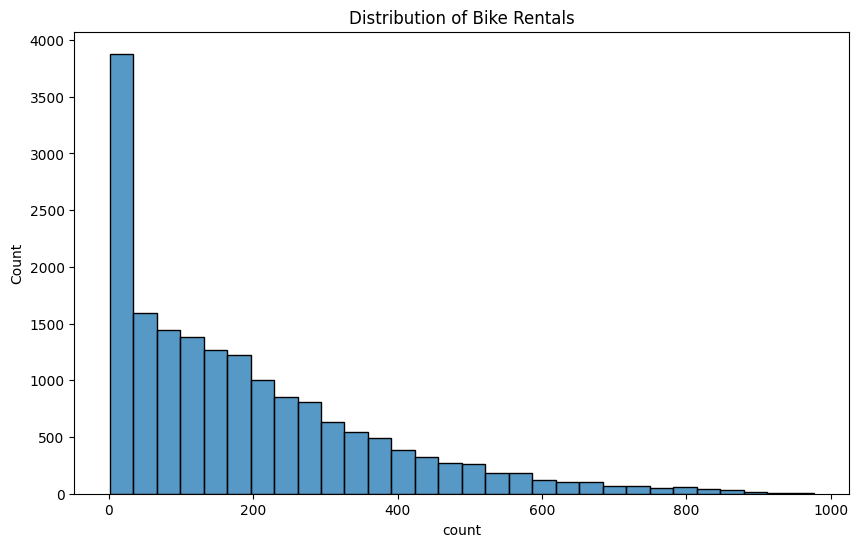

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['count'], bins=30)
plt.title('Distribution of Bike Rentals')
plt.show()


##### Average bike rentals on working day vs holidays

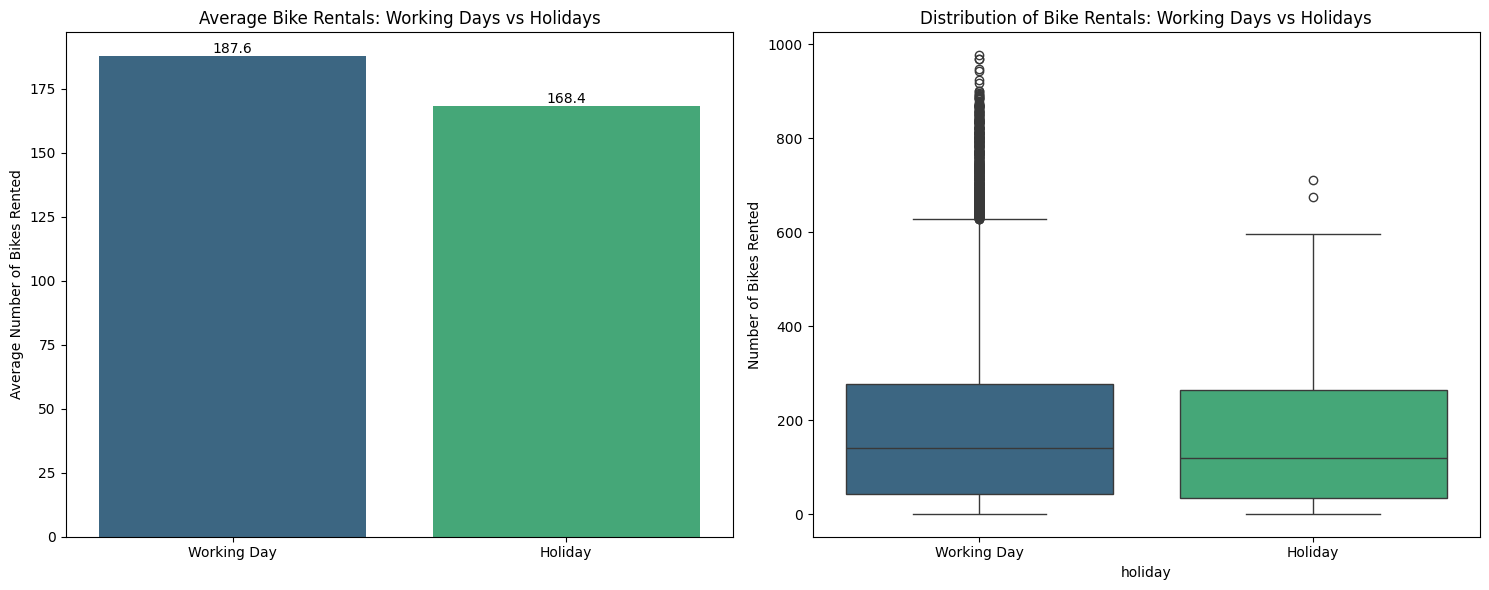

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

average_by_day = df.groupby('holiday')['count'].mean()

sns.barplot(x=['Working Day', 'Holiday'], 
            y=average_by_day.values,
            ax=ax1,
            palette='viridis')

ax1.set_title('Average Bike Rentals: Working Days vs Holidays')
ax1.set_ylabel('Average Number of Bikes Rented')
ax1.text(0, average_by_day[0], f'{average_by_day[0]:.1f}', ha='center', va='bottom')
ax1.text(1, average_by_day[1], f'{average_by_day[1]:.1f}', ha='center', va='bottom')

sns.boxplot(data=df, x='holiday', y='count', ax=ax2, palette='viridis')
ax2.set_xticklabels(['Working Day', 'Holiday'])
ax2.set_title('Distribution of Bike Rentals: Working Days vs Holidays')
ax2.set_ylabel('Number of Bikes Rented')

plt.tight_layout()
plt.show()

On average, more bikes are rented on the working days rather than the holidays. Also, there are significantly more seemingly outliers in the working day numbers which needs further investigation before dealing with them.

##### Peak hour analysis on working days vs holidays

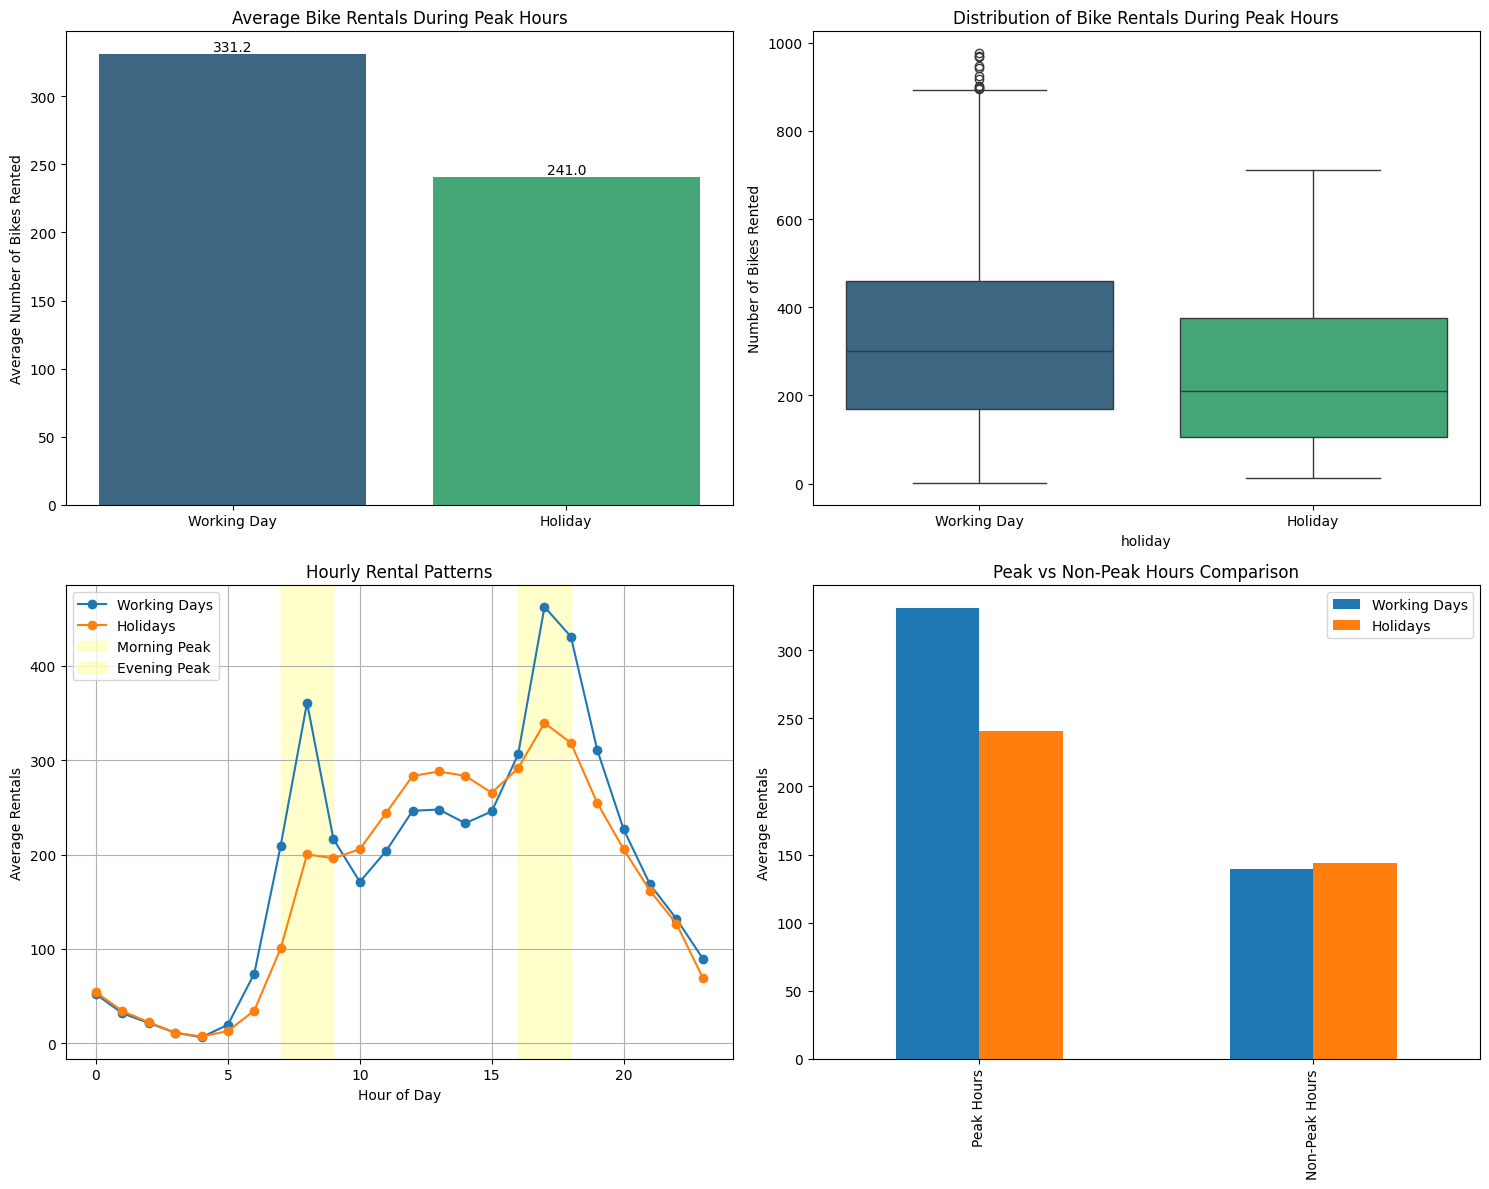

In [37]:
peak_hours_data = df[df['is_peak_hour'] == 1].copy()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))



average_by_day = peak_hours_data.groupby('holiday')['count'].mean()

sns.barplot(x=['Working Day', 'Holiday'], 
            y=average_by_day.values,
            ax=ax1,
            palette='viridis')

ax1.set_title('Average Bike Rentals During Peak Hours')
ax1.set_ylabel('Average Number of Bikes Rented')
ax1.text(0, average_by_day[0], f'{average_by_day[0]:.1f}', ha='center', va='bottom')
ax1.text(1, average_by_day[1], f'{average_by_day[1]:.1f}', ha='center', va='bottom')

sns.boxplot(data=peak_hours_data, x='holiday', y='count', ax=ax2, palette='viridis')
ax2.set_xticklabels(['Working Day', 'Holiday'])
ax2.set_title('Distribution of Bike Rentals During Peak Hours')
ax2.set_ylabel('Number of Bikes Rented')

working_days = df[df['holiday'] == 0].groupby('hour')['count'].mean()
holidays = df[df['holiday'] == 1].groupby('hour')['count'].mean()

ax3.plot(working_days.index, working_days.values, label='Working Days', marker='o')
ax3.plot(holidays.index, holidays.values, label='Holidays', marker='o')
ax3.axvspan(7, 9, alpha=0.2, color='yellow', label='Morning Peak')
ax3.axvspan(16, 18, alpha=0.2, color='yellow', label='Evening Peak')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Average Rentals')
ax3.set_title('Hourly Rental Patterns')
ax3.legend()
ax3.grid(True)

peak_comparison = pd.DataFrame({
    'Working Days': [
        df[(df['holiday'] == 0) & (df['is_peak_hour'] == 1)]['count'].mean(),
        df[(df['holiday'] == 0) & (df['is_peak_hour'] == 0)]['count'].mean()
    ],
    'Holidays': [
        df[(df['holiday'] == 1) & (df['is_peak_hour'] == 1)]['count'].mean(),
        df[(df['holiday'] == 1) & (df['is_peak_hour'] == 0)]['count'].mean()
    ]
}, index=['Peak Hours', 'Non-Peak Hours'])

peak_comparison.plot(kind='bar', ax=ax4)
ax4.set_title('Peak vs Non-Peak Hours Comparison')
ax4.set_ylabel('Average Rentals')

plt.tight_layout()
plt.show()

Here, we can see that the peak hour during the working day has a big influence on the rental numbers. During non-peak hours, the number of rentals is fairly similar between working days and holidays.

#### Analyzing effect of temperature on bike rentals

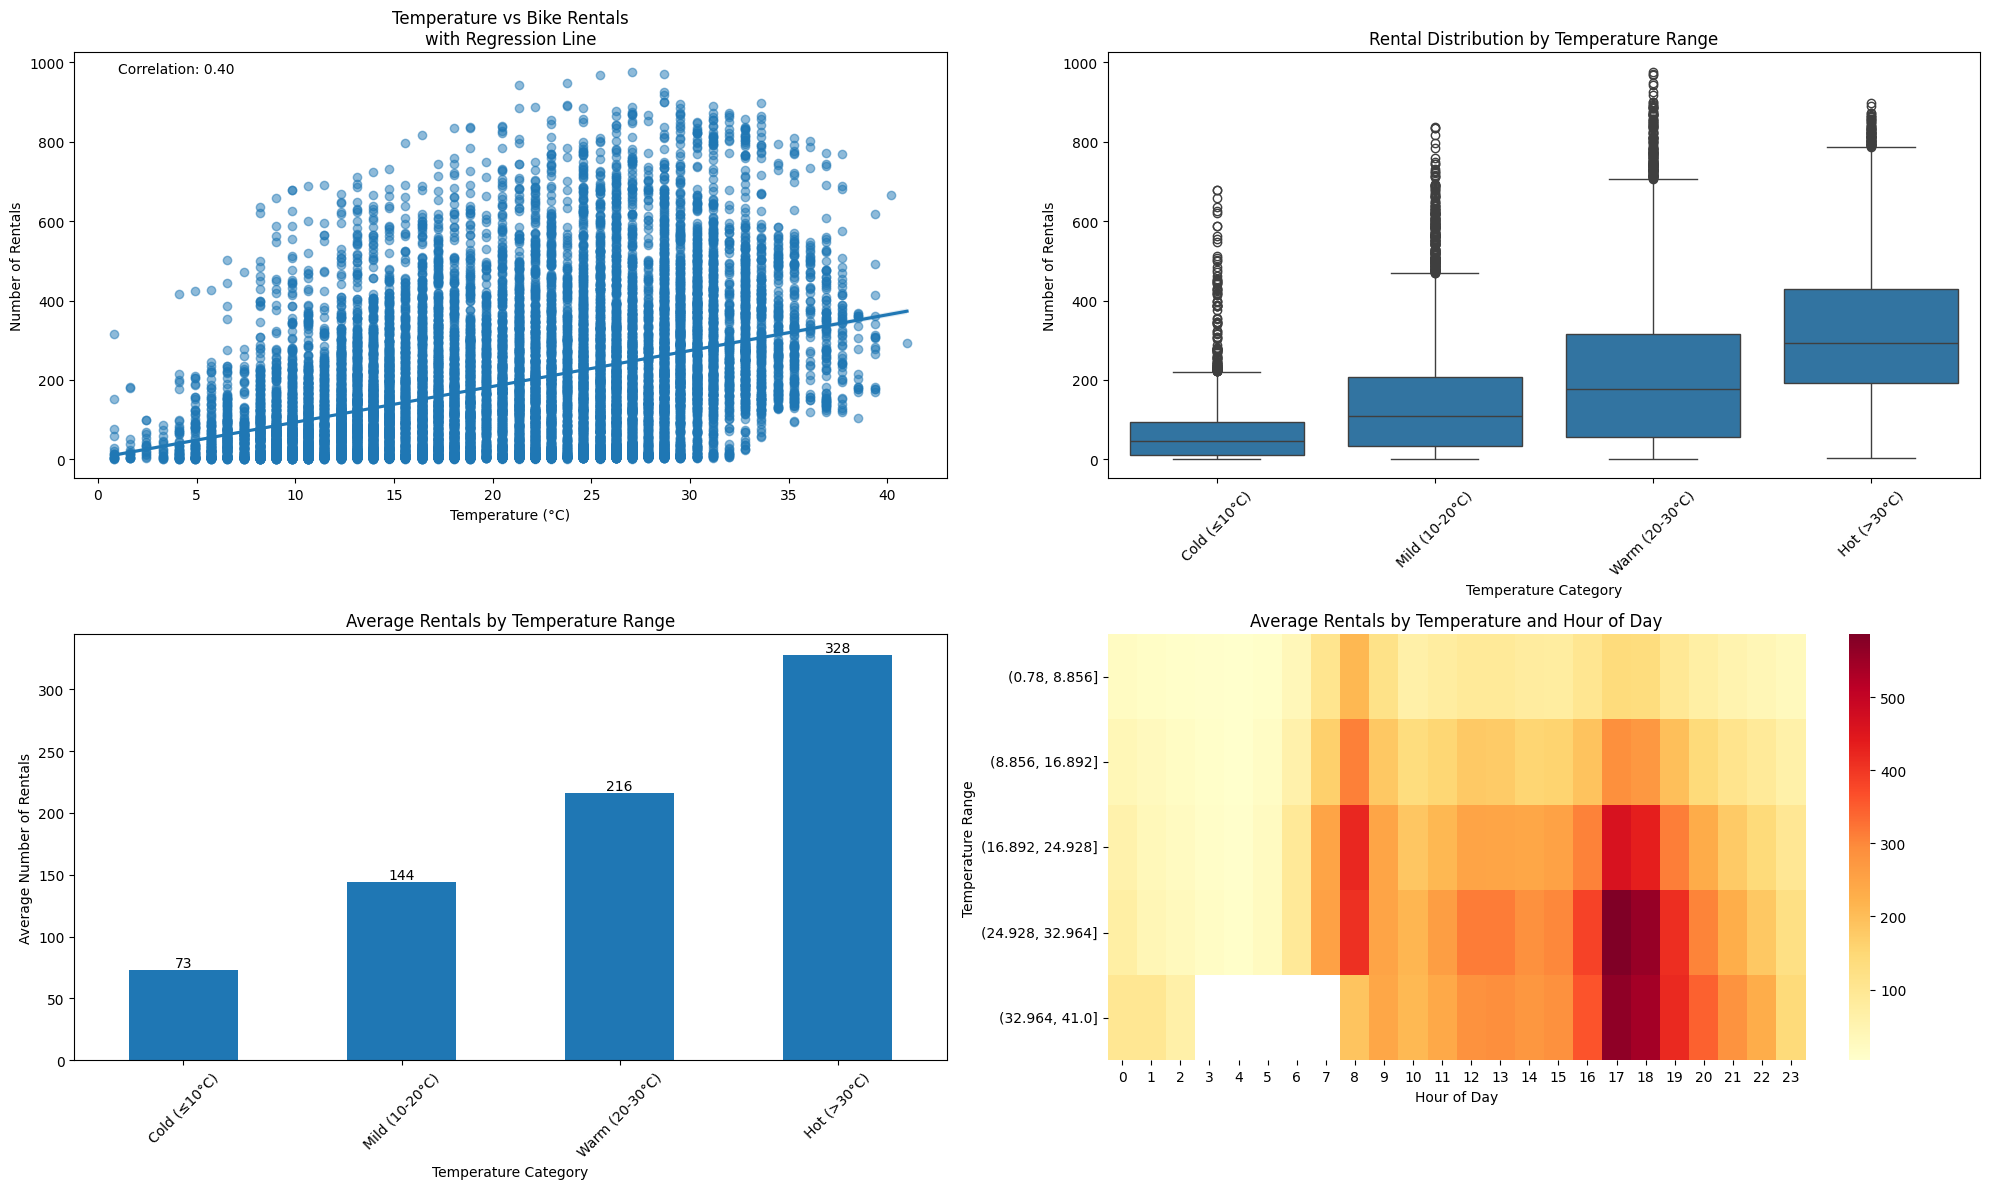

In [38]:
df['temp_category'] = pd.cut(df['temp'], 
                            bins=[-np.inf, 10, 20, 30, np.inf],
                            labels=['Cold (≤10°C)', 'Mild (10-20°C)', 
                                  'Warm (20-30°C)', 'Hot (>30°C)'])

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
sns.regplot(data=df, x='temp', y='count', scatter_kws={'alpha':0.5}, ax=ax1)
ax1.set_title('Temperature vs Bike Rentals\nwith Regression Line', fontsize=12)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Number of Rentals')

correlation = df['temp'].corr(df['count'])
ax1.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=ax1.transAxes, fontsize=10)

ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=df, x='temp_category', y='count', ax=ax2)
ax2.set_title('Rental Distribution by Temperature Range', fontsize=12)
ax2.set_xlabel('Temperature Category')
ax2.set_ylabel('Number of Rentals')
plt.xticks(rotation=45)

ax3 = fig.add_subplot(gs[1, 0])
avg_by_temp = df.groupby('temp_category')['count'].mean()
avg_by_temp.plot(kind='bar', ax=ax3)
ax3.set_title('Average Rentals by Temperature Range', fontsize=12)
ax3.set_xlabel('Temperature Category')
ax3.set_ylabel('Average Number of Rentals')
plt.xticks(rotation=45)

for i, v in enumerate(avg_by_temp):
    ax3.text(i, v, f'{v:.0f}', ha='center', va='bottom')

ax4 = fig.add_subplot(gs[1, 1])
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
pivot_table = df.pivot_table(values='count', 
                            index=pd.cut(df['temp'], bins=5), 
                            columns=df['hour'], 
                            aggfunc='mean')

sns.heatmap(pivot_table, cmap='YlOrRd', ax=ax4)
ax4.set_title('Average Rentals by Temperature and Hour of Day', fontsize=12)
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Temperature Range')

plt.tight_layout()
plt.show()

Here, we can examine that the number of rentals are more during the hotter climate than the colder ones which follows the general convention of logic. Also, the final graph displays that during the peak hours of the warm climate, there are significantly more rentals happening.

#### Handling outliers

In [10]:
def treat_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
        
        print(f"\nOutliers treated for {col}:")
        print(f"Before - Min: {df[col].min():.2f}, Max: {df[col].max():.2f}")
        print(f"After  - Min: {df_clean[col].min():.2f}, Max: {df_clean[col].max():.2f}")
    
    return df_clean

numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
df_clean = treat_outliers(df, numerical_features)


Outliers treated for temp:
Before - Min: 0.82, Max: 41.00
After  - Min: 0.82, Max: 41.00

Outliers treated for atemp:
Before - Min: 0.00, Max: 50.00
After  - Min: 0.00, Max: 50.00

Outliers treated for humidity:
Before - Min: 0.00, Max: 100.00
After  - Min: 3.00, Max: 100.00

Outliers treated for windspeed:
Before - Min: 0.00, Max: 57.00
After  - Min: 0.00, Max: 31.99


#### Features selection and preparation

In [11]:
features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 
           'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 
           'dayofweek', 'is_peak_hour']

X = df_clean[features]
y = df_clean['count']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Regular Regression Approach

In [13]:
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 'dayofweek']
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'is_peak_hour']


In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [16]:
regular_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [17]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5]
}

In [18]:
grid_search = GridSearchCV(regular_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed',
                                                                          'hour',
                                                                          'day',
                                                                          'month',
                                                                          'year',
                                                                          'dayofweek']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season',
                                                                          'holiday',
                                                                          'workingday',
                                                                          'weather',
                                                                          'is_peak_hour'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='r2')

In [19]:
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best cross-validation score: 0.9590289485959286


In [20]:
y_pred_regular = grid_search.predict(X_test)
regular_r2 = r2_score(y_test, y_pred_regular)
regular_rmse = np.sqrt(mean_squared_error(y_test, y_pred_regular))


In [21]:
print(f"\nRegular Model Test Results:")
print(f"R2 Score: {regular_r2:.4f}")
print(f"RMSE: {regular_rmse:.2f}")


Regular Model Test Results:
R2 Score: 0.9645
RMSE: 32.83


## Optimal Binning Approach

In [22]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('binner', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))
])


In [23]:
binning_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [24]:
binning_pipeline = Pipeline([
    ('preprocessor', binning_preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [25]:
grid_search_binning = GridSearchCV(binning_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_binning.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feat

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('binner',
                                                                                          KBinsDiscretizer(encode='ordinal'))]),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed',
                                                                          'hour',
                                                                          'day',
                                                                          'month',
                                                                          'year',
                                                                          'dayofweek']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season',
                                                                          'holiday',
                                                                          'workingday',
                                                                          'weather',
                                                                          'is_peak_hour'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='r2')

In [26]:
print("\nBest parameters:", grid_search_binning.best_params_)
print("Best cross-validation score:", grid_search_binning.best_score_)



Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best cross-validation score: 0.7591562911093713


In [27]:
y_pred_binning = grid_search_binning.predict(X_test)
binning_r2 = r2_score(y_test, y_pred_binning)
binning_rmse = np.sqrt(mean_squared_error(y_test, y_pred_binning))


In [28]:
print(f"\nOptimal Binning Model Test Results:")
print(f"R2 Score: {binning_r2:.4f}")
print(f"RMSE: {binning_rmse:.2f}")


Optimal Binning Model Test Results:
R2 Score: 0.7562
RMSE: 86.06


## Comparison of two approaches

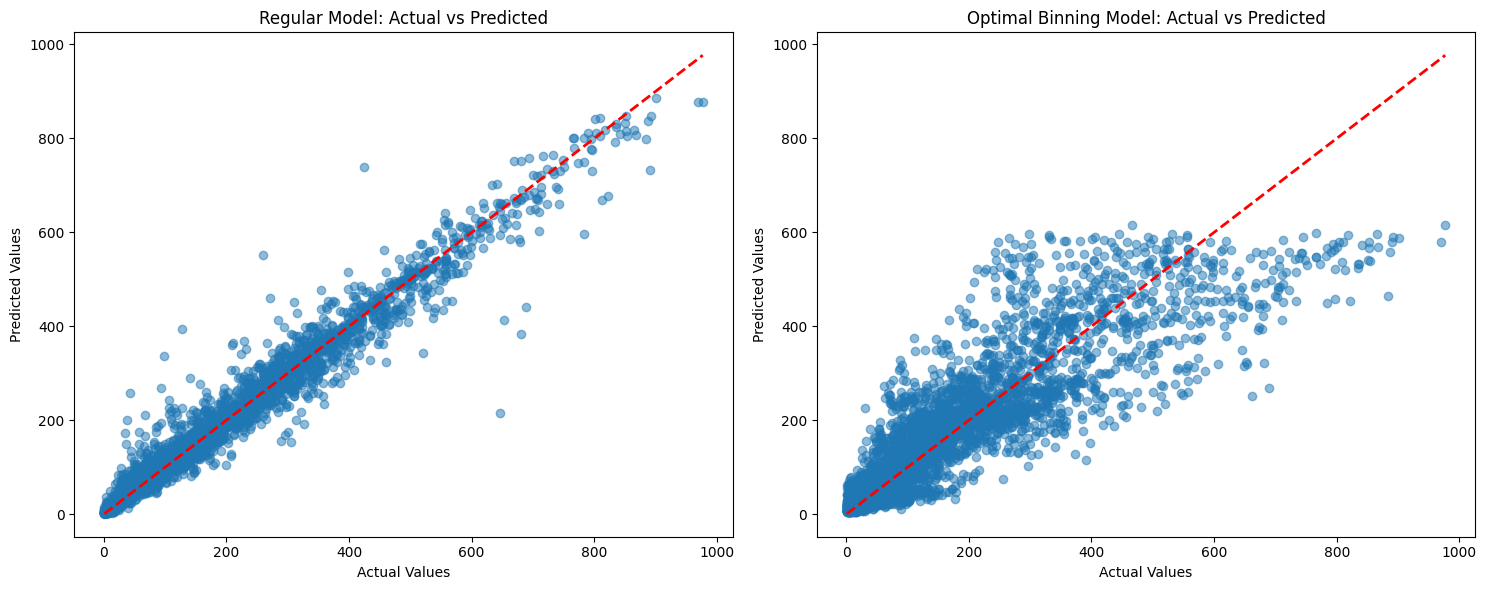

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Regular model
ax1.scatter(y_test, y_pred_regular, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Regular Model: Actual vs Predicted')

# Binning model
ax2.scatter(y_test, y_pred_binning, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Optimal Binning Model: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [30]:
if regular_r2 > binning_r2:
    best_model = grid_search.best_estimator_
    model_name = "Regular Model"
else:
    best_model = grid_search_binning.best_estimator_
    model_name = "Optimal Binning Model"

In [31]:
feature_names = (numeric_features + 
                [f"{feat}_{val}" for feat, vals in 
                 zip(categorical_features, 
                     best_model.named_steps['preprocessor']
                     .named_transformers_['cat'].categories_) 
                 for val in vals[1:]])

#### Feature importance

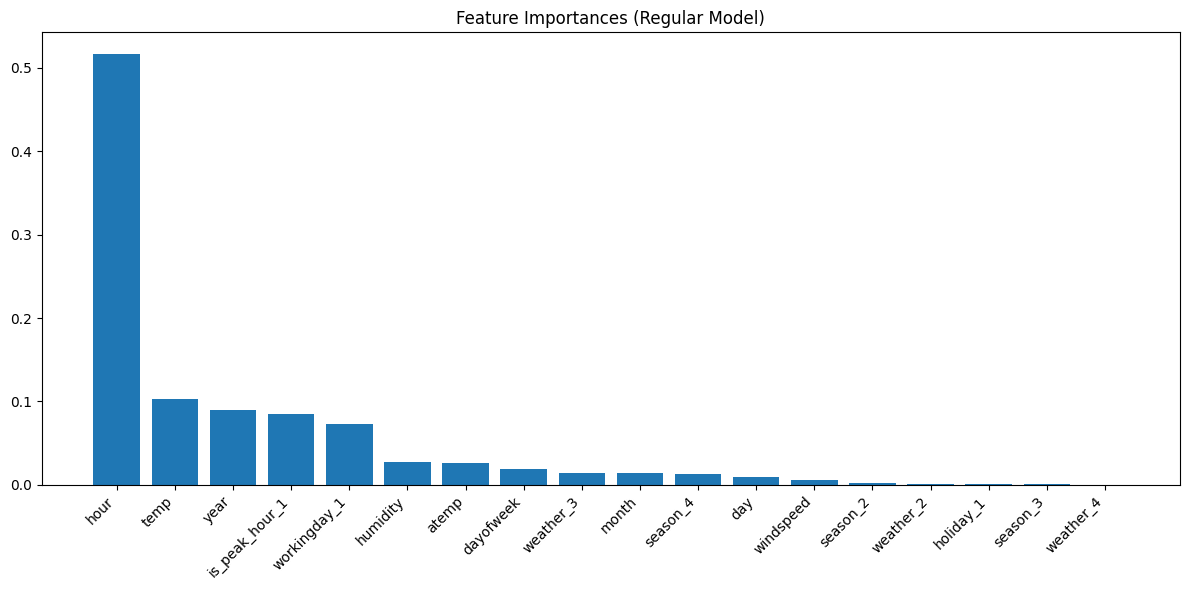

In [32]:
importances = best_model.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title(f'Feature Importances ({model_name})')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [34]:
print("\nFinal Model Comparison:")
print(f"Regular Model - R2: {regular_r2:.4f}, RMSE: {regular_rmse:.2f}")
print(f"Optimal Binning Model - R2: {binning_r2:.4f}, RMSE: {binning_rmse:.2f}")


print("\nThe Regular Model performed better")


Final Model Comparison:
Regular Model - R2: 0.9645, RMSE: 32.83
Optimal Binning Model - R2: 0.7562, RMSE: 86.06

The Regular Model performed better


The Regular Model performed significantly better than the Optimal Binning Model
R² Score interpretation:

Regular Model (0.9645): Explains 96.45% of the variance in bike rentals
Optimal Binning Model (0.7562): Only explains 75.62% of the variance


RMSE interpretation:

Regular Model (32.83): On average, predictions are off by about 33 bikes
Optimal Binning Model (86.06): On average, predictions are off by about 86 bikes


Key Takeaway: The Regular Model is clearly superior, with both higher accuracy (R²) and lower prediction error (RMSE), making it the better choice for predicting bike rental demand.